In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
import rasterio
import xarray as xr
import matplotlib.pyplot as plt

Found files: ['CHIRPS_Brahmaputra_1984.tif']

--- Loading CHIRPS_Brahmaputra_1984.tif (year 1984) ---
  CRS: EPSG:4326
  Bounds: BoundingBox(left=73.35000000000002, bottom=22.45, right=97.80000000000003, top=31.5)
  Transform: | 0.05, 0.00, 73.35|
| 0.00,-0.05, 31.50|
| 0.00, 0.00, 1.00|
  Pixel size (approx.): 0.05 deg in x, -0.05 deg in y
  shape (bands, y, x): (306, 181, 489)
  number of band names: 306
  first date: 1984-03-01 00:00:00 last date: 1984-12-31 00:00:00
  value range (ignoring NaN): 0.0 to 403.1203308105469

Combined precip DataArray:
<xarray.DataArray 'precip' (time: 306, y: 181, x: 489)> Size: 108MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],

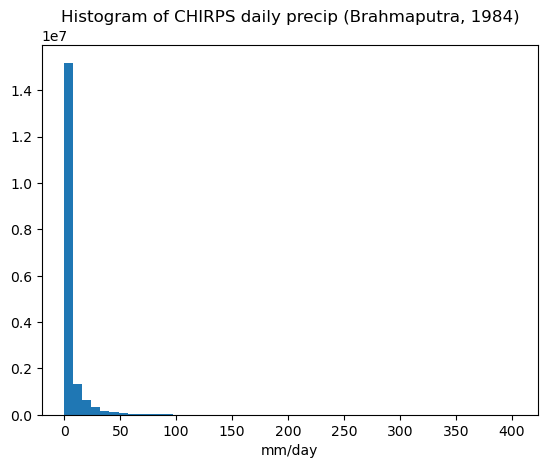

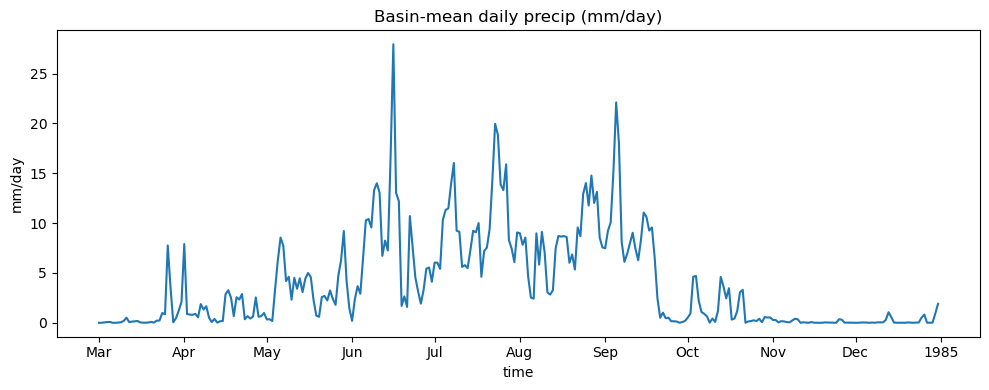

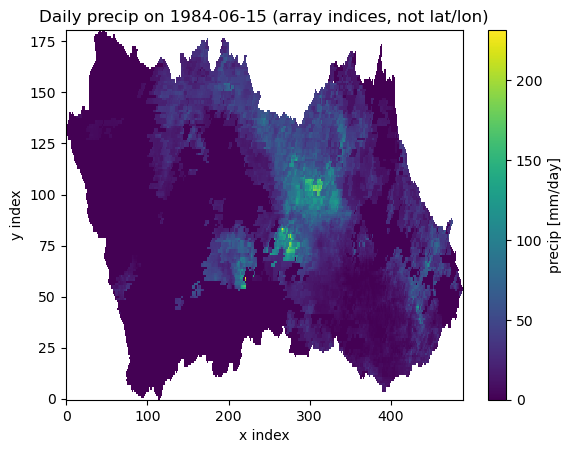


QC5: time series at pixel (y=50, x=50):
<xarray.DataArray 'precip' (time: 5)> Size: 20B
array([nan, nan, nan, nan, nan], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 40B 1984-03-01 1984-03-02 ... 1984-03-05
    y        int32 4B 50
    x        int32 4B 50
Attributes:
    units:    mm/day
    year:     1984
Number of NaN values at pixel (y=50, x=50): 306

QC6: valid pixel count per day:
  min: 58619 max: 58619


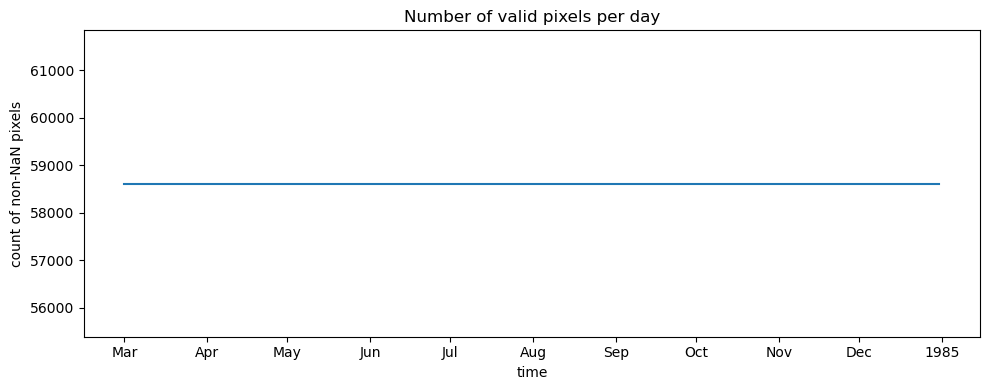


QC7: fraction of valid days per pixel:
  min: 0.0 max: 1.0


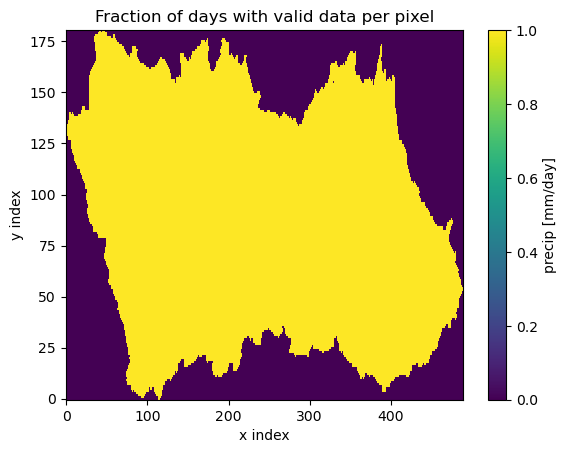

In [8]:
# -----------------------------
# 1. Paths
# -----------------------------

DATA_DIR = Path(r"C:\Users\Jelle Gortemaker\Downloads")  # folder with TIFFs

year_files = sorted(DATA_DIR.glob("CHIRPS_Brahmaputra_*.tif"))
print("Found files:", [f.name for f in year_files])

if not year_files:
    raise FileNotFoundError(
        "No files matching 'CHIRPS_Brahmaputra_*.tif' in "
        f"{DATA_DIR}. Check the folder and file names."
    )

# -----------------------------
# 2. Load yearly files into xarray
# -----------------------------

year_das = []

for tif in year_files:
    year = int(tif.stem.split("_")[-1])   # assumes ..._YYYY.tif
    print(f"\n--- Loading {tif.name} (year {year}) ---")

    with rasterio.open(tif) as ds:
        # ---- georeferencing sanity (QC 8) ----
        print("  CRS:", ds.crs)
        print("  Bounds:", ds.bounds)
        print("  Transform:", ds.transform)
        print("  Pixel size (approx.):", ds.transform.a, "deg in x,",
              ds.transform.e, "deg in y")

        # data: (bands, y, x)
        data = ds.read(masked=True)   # masked array with nodata masked
        data = data.filled(np.nan)    # convert masked to NaN

        band_names = ds.descriptions  # e.g. ('19840301', '19840302', ...)
        print("  shape (bands, y, x):", data.shape)
        print("  number of band names:", len(band_names))

        # parse dates from band names
        time = pd.to_datetime(list(band_names), format="%Y%m%d")
        print("  first date:", time[0], "last date:", time[-1])

        # basic value range check
        print("  value range (ignoring NaN):",
              float(np.nanmin(data)), "to", float(np.nanmax(data)))

        # build DataArray for this year
        y = np.arange(ds.height)
        x = np.arange(ds.width)

    da_year = xr.DataArray(
        data,
        dims=("time", "y", "x"),
        coords={"time": time, "y": y, "x": x},
        name="precip",
        attrs={"units": "mm/day", "year": year},
    )

    year_das.append(da_year)

# combine all years
precip = xr.concat(year_das, dim="time").sortby("time")
print("\nCombined precip DataArray:")
print(precip)
print("Total time steps:", precip.sizes["time"])
print("y size:", precip.sizes["y"], "x size:", precip.sizes["x"])

# -----------------------------
# 3. Quality checks
# -----------------------------

# QC 1: check for non-physical values
print("\nQC1: non-physical values check (first 10 days):")
subset = precip.isel(time=slice(0, 10))
print("  min:", float(subset.min()), "max:", float(subset.max()))
print("  any negative?:", bool((subset < 0).any()))

# QC 2: plot histogram of values for one year (e.g. 1984)
year_1984 = precip.sel(time=slice("1984-03-01", "1984-12-31"))
plt.figure()
year_1984.plot.hist(bins=50)
plt.title("Histogram of CHIRPS daily precip (Brahmaputra, 1984)")
plt.xlabel("mm/day")
plt.show()

# QC 3: basin-mean daily time series (rough sanity)
ts_mean = precip.mean(dim=("y", "x"))  # mean over all pixels
plt.figure(figsize=(10, 4))
ts_mean.plot()
plt.title("Basin-mean daily precip (mm/day)")
plt.ylabel("mm/day")
plt.tight_layout()
plt.show()

# QC 4: pick a single day and plot the spatial field (index space)
sample_date = "1984-06-15"
if sample_date in precip.time.dt.strftime("%Y-%m-%d").values:
    da_day = precip.sel(time=sample_date)
    plt.figure()
    da_day.plot()
    plt.title(f"Daily precip on {sample_date} (array indices, not lat/lon)")
    plt.xlabel("x index")
    plt.ylabel("y index")
    plt.show()
else:
    print(f"{sample_date} not found in time coordinate")

# QC 5: time series at one pixel
y_idx, x_idx = 50, 50
ts_pixel = precip.isel(y=y_idx, x=x_idx)
print(f"\nQC5: time series at pixel (y={y_idx}, x={x_idx}):")
print(ts_pixel.head())

num_nans = int(ts_pixel.isnull().sum())
print(f"Number of NaN values at pixel (y={y_idx}, x={x_idx}): {num_nans}")

# QC 6: mask stability — number of valid pixels per day
valid_per_day = precip.notnull().sum(dim=("y", "x"))
print("\nQC6: valid pixel count per day:")
print("  min:", int(valid_per_day.min().values),
      "max:", int(valid_per_day.max().values))

plt.figure(figsize=(10, 4))
valid_per_day.plot()
plt.title("Number of valid pixels per day")
plt.ylabel("count of non-NaN pixels")
plt.tight_layout()
plt.show()

# If min == max, the mask is perfectly stable; if there is variation,
# some days have slightly more/less missing data.

# QC 7: fraction of valid days per pixel (over full period)
valid_days_per_pixel = precip.notnull().sum(dim="time")
total_days = precip.sizes["time"]
fraction_valid = valid_days_per_pixel / total_days

print("\nQC7: fraction of valid days per pixel:")
print("  min:", float(fraction_valid.min()),
      "max:", float(fraction_valid.max()))

plt.figure()
fraction_valid.plot()
plt.title("Fraction of days with valid data per pixel")
plt.xlabel("x index")
plt.ylabel("y index")
plt.show()